### Dependencias 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from functools import reduce

from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from itertools import combinations

cf.go_offline()

### Lectura de datos

In [7]:
df = pd.read_excel('../Datos/Cuestionario Lúdico (Respuestas).xlsx')
df.head()

,Marca temporal,Edad (años entero),Signo del zodiaco,Signo del zodiaco chino,Sexo (biológico),"Tamaño del zapato (22,23,24,etc)",Tiempo promedio diario que pasan en redes sociales (minutos),¿Tienes pareja?,¿Te gusta el reggaeton?,¿Te gusta el futbol?,¿Usas Tiktok?,Estatura (cms),Peso (kg)
0,2023-03-10 18:00:02.133,22,Acuario,Serpiente,Hombre,25.0,180,Sí,Sí,Sí,Sí,172,62.0
1,2023-03-10 18:00:52.170,21,Aries,Serpiente,Mujer,24.0,240,Sí,Sí,No,Sí,160,60.0
2,2023-03-10 18:01:37.361,21,Libra,Serpiente,Hombre,28.0,90,No,Sí,Sí,No,172,85.0
3,2023-03-10 18:01:44.124,22,Virgo,Dragón,Mujer,24.0,180,No,Sí,No,Sí,158,62.0
4,2023-03-10 18:01:49.099,21,Libra,Conejo,Hombre,29.0,120,Sí,Sí,Sí,Sí,181,89.0


### Categorización de Variables

In [8]:
df.columns

Index(['Marca temporal', 'Edad (años entero)', 'Signo del zodiaco',
       'Signo del zodiaco chino', 'Sexo (biológico)',
       'Tamaño del zapato (22,23,24,etc)',
       'Tiempo promedio diario que pasan en redes sociales (minutos)',
       '¿Tienes pareja?', '¿Te gusta el reggaeton?', '¿Te gusta el futbol?',
       '¿Usas Tiktok?', 'Estatura (cms)', 'Peso (kg)'],
      dtype='object')

In [9]:
# Variables continuas
varc = ['Edad (años entero)','Tamaño del zapato (22,23,24,etc)',
        'Tiempo promedio diario que pasan en redes sociales (minutos)','Estatura (cms)', 'Peso (kg)']
# Variables discretas
vard = ['Signo del zodiaco',
       'Signo del zodiaco chino']
# Variables de prueba (test)
vart = ['Sexo (biológico)','¿Tienes pareja?', '¿Te gusta el reggaeton?', '¿Te gusta el futbol?',
       '¿Usas Tiktok?']

### Visualización de Datos

Como solo podemos visualizar en máximo 3 dimensiones, vamos a hacer todas las combinaciones posibles de 3 variables.

In [ ]:
com = combinations(varc, 3)

# Graficar todas las combinaciones de 3 variables continuas.
for c in com:
    c = tuple(c)
    df[varc].iplot(kind = 'scatter3d', mode = 'markers', x=c[0], y=c[1],z=c[2], xTitle=c[0], yTitle=c[1], zTitle=c[2])

### Partición de Datos

* La función train_test_split de sklearn nos permite dividir los datos en dos conjuntos, uno de entrenamiento y otro de test.
* La función train.reset_index(drop=True) nos permite resetear los índices de los datos de entrenamiento. inplace=True nos permite modificar el dataframe original.

In [11]:
train, test = train_test_split(df,train_size = 0.7)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

### Reducción de dimensionalidad

* La función make_pipeline de sklearn nos permite crear una canalización utilizando los estimadores proporcionados. En este caso, utilizamos PCA para reducir la dimensionalidad conservando la mayor parte de información y StandardScaler para estandarizar los datos.
* StandardScaler() nos permite estandarizar los datos (media = 0 y varianza = 1). Esto es útil cuando se busca que los datos tengan la misma escala.
* MinMaxScaler() transforma las características escalandolas a un rango de (0,1), aunque esto se puede personalizar.
* Con .explained_variance_ratio_ podemos ver la varianza explicada por cada componente principal. La varianza explicada se refiere a la proporción de varianza en los datos originales que se puede atribuir a cada componente principal. En este caso, vemos que la primera componente principal explica el 53% de la varianza, la segunda el 21% y la tercera el 18%. Esto nos indica que podemos reducir la dimensionalidad a 3 componentes principales sin perder mucha información.

** Un objeto de canalización (pipeline) es un estimador compuesto por varios estimadores. Estos estimadores se ejecutan secuencialmente y el resultado de cada uno se pasa como parámetro al siguiente. El último estimador es el que se utiliza para predecir.**

In [15]:
# Creamos el pipeline.
pipe = make_pipeline(StandardScaler(), PCA(n_components=3), MinMaxScaler())
# Entenamos el conjunto de entrenamiento.
pipe.fit(train[varc])
# Mostramos la varianza explicada.
print (pipe.steps[1][1].explained_variance_ratio_)
# Mostramos la varianza explicada acumulada.
print (pipe.steps[1][1].explained_variance_ratio_.cumsum())

[0.5373828  0.21159503 0.18567185]
[0.5373828  0.74897783 0.93464969]


In [13]:
# Transformamos el conjunto de entrenamiento.
Xp = pd.DataFrame(pipe.transform(train[varc]), columns = ['PC1','PC2','PC3'])
Xp.head()

,PC1,PC2,PC3
0,0.487266,5.420002e-01,0.370547
1,0.652442,4.776587e-01,0.758556
2,0.099346,3.885781e-16,0.374971
3,0.374223,3.913714e-01,0.171178
4,0.804808,7.187928e-01,0.329958


array([[<Axes: title={'center': 'Edad (años entero)'}>,
        <Axes: title={'center': 'Tamaño del zapato (22,23,24,etc)'}>],
       [<Axes: title={'center': 'Tiempo promedio diario que pasan en redes sociales (minutos)'}>,
        <Axes: title={'center': 'Estatura (cms)'}>],
       [<Axes: title={'center': 'Peso (kg)'}>, <Axes: >]], dtype=object)

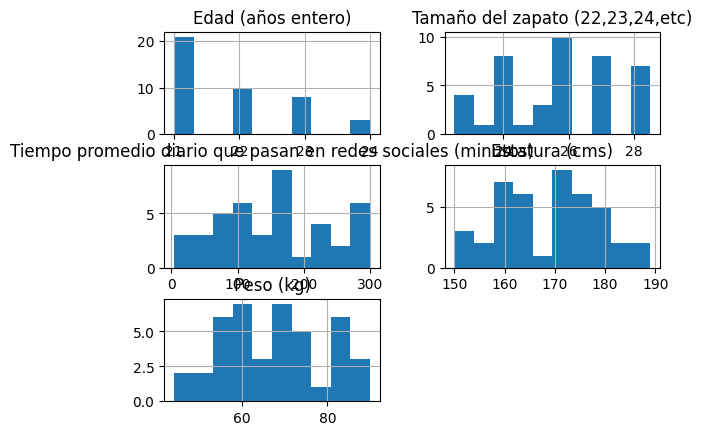

In [16]:
train[varc].hist()

### Entrenamiento del modelo

In [17]:
vart

['Sexo (biológico)',
 '¿Tienes pareja?',
 '¿Te gusta el reggaeton?',
 '¿Te gusta el futbol?',
 '¿Usas Tiktok?']

In [20]:
# Asignamos la variable objetivo.
target = vart[-1]
# Creamos una nueva columna con los valores de la variable objetivo.
Xp[target]=train[target]
Xp.head()

,PC1,PC2,PC3,¿Usas Tiktok?
0,0.487266,5.420002e-01,0.370547,Sí
1,0.652442,4.776587e-01,0.758556,Sí
2,0.099346,3.885781e-16,0.374971,Sí
3,0.374223,3.913714e-01,0.171178,Sí
4,0.804808,7.187928e-01,0.329958,No


In [19]:

Xp.iplot(kind='scatter3d',mode='markers',x='PC1',y='PC2',z='PC3',xTitle='PC1',yTitle='PC2',zTitle='PC3',categories=target)

* La función accuracy_score nos permite calcular la precisión del modelo. La precisión es la proporción de muestras correctamente clasificadas, tanto en el entrenamiento como en la prueba de validación. 

In [21]:
# Creamos el modelo de perceptron.
mod = Perceptron()
# Entrenamos (en este caso, nuestras X son las componentes principales y la Y es la target).
mod.fit(Xp[['PC1','PC2','PC3']],Xp[target])

# Transformamos el conjunto de validación (para que sea de tres dimensiones), i.e. el conjunto donde 
# ponemos a prueba el clasificador.
valid = pd.DataFrame(pipe.transform(test[varc]),columns=['PC1','PC2','PC3'])

print({'train':accuracy_score(Xp[target],mod.predict(Xp[['PC1','PC2','PC3']])),
'test':accuracy_score(test[target],mod.predict(valid[['PC1','PC2','PC3']]))})

{'train': 0.5952380952380952, 'test': 0.6666666666666666}


In [22]:
mod = PassiveAggressiveClassifier()
mod.fit(Xp[['PC1','PC2','PC3']],Xp[target])

valid = pd.DataFrame(pipe.transform(test[varc]),columns=['PC1','PC2','PC3'])

print({'train':accuracy_score(Xp[target],mod.predict(Xp[['PC1','PC2','PC3']])),
'test':accuracy_score(test[target],mod.predict(valid[['PC1','PC2','PC3']]))})

{'train': 0.5476190476190477, 'test': 0.4444444444444444}


In [23]:
mod = SVC()
mod.fit(Xp[['PC1','PC2','PC3']],Xp[target])

valid = pd.DataFrame(pipe.transform(test[varc]),columns=['PC1','PC2','PC3'])

print({'train':accuracy_score(Xp[target],mod.predict(Xp[['PC1','PC2','PC3']])),
'test':accuracy_score(test[target],mod.predict(valid[['PC1','PC2','PC3']]))})

{'train': 0.7380952380952381, 'test': 0.7222222222222222}


### Mejora con Hiperparámetros

In [24]:

hp = {'C':[0.1,1,10,100,1000],'kernel':['linear','rbf','poly'],'degree':[2,3,4,5,6]}
reduce(lambda x,y: x*y,[len(hp[k]) for k in hp])
mod = SVC()

* La función GridSearchCV nos permite realizar una búsqueda de grilla sobre los hiperparámetros del modelo, probando las diferentes combinaciones de valores para cada hiperparámetro y ajustando el modelo con cada combinación en un modelo por separado.

In [25]:
grid = GridSearchCV(mod,hp,scoring='accuracy',cv=5,verbose=1,n_jobs=-1)
# Entrenamos el grid.
grid.fit(Xp[['PC1','PC2','PC3']],Xp[target])
# Obtenemos el mejor modelo.
mod = grid.best_estimator_
# Obtenemos los parámetros del mejor modelo.
print(grid.best_params_)

# Ya podemos utilizar el best como un modelo nuevo
mod.fit(Xp[['PC1','PC2','PC3']],Xp[target])
print({'train':accuracy_score(Xp[target],mod.predict(Xp[['PC1','PC2','PC3']])),
'test':accuracy_score(test[target],mod.predict(valid[['PC1','PC2','PC3']]))})

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 1, 'degree': 3, 'kernel': 'poly'}
{'train': 0.6666666666666666, 'test': 0.5555555555555556}


### Validación con datos nuevos

* Con .T obtenemos la transpuesta. 

In [34]:
# Datos del profesor (que no contesto dentro de la encuesta).
profe = pd.Series(dict(zip(varc, [36,  30,  180,  184,  59])))
# Convertimos a dataframe.
profe = pd.DataFrame(profe).T
profe


,Edad (años entero),"Tamaño del zapato (22,23,24,etc)",Tiempo promedio diario que pasan en redes sociales (minutos),Estatura (cms),Peso (kg)
0,36,30,180,184,59


In [35]:
# Transformamos los datos del profesor y predecimos.
mod.predict(pd.DataFrame(pipe.transform(profe),columns=['PC1','PC2','PC3']))

array(['No'], dtype=object)

### Importancia de las variables

In [29]:
# Creamos el selector de variables.
sk = SelectKBest(k=len(varc))
# Entrenamos el selector de variables.
sk.fit(train[varc],train[target])
# Mostramos las variables ordenadas por su score.
pd.DataFrame({'var':varc,'score':sk.scores_}).sort_values('score',ascending=False).iplot(kind='bar',x='var',y='score')

In [36]:
train[varc+[target]].groupby(target).mean().T

¿Usas Tiktok?,No,Sí
Edad (años entero),21.75000,21.884615
"Tamaño del zapato (22,23,24,etc)",25.78125,25.615385
Tiempo promedio diario que pasan en redes sociales (minutos),138.18750,179.269231
Estatura (cms),169.25000,169.038462
Peso (kg),65.63750,68.423077
